# Preliminary Notes and Vocab

* nn.Sequantial - wrapper to manage multiple layers
### Additional ressources 

* https://playground.tensorflow.org

# Dependencies

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm

print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Torch version: 2.1.2
Using device: mps


# Fake Data

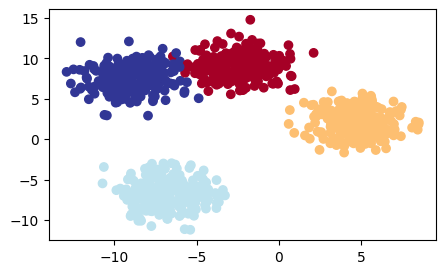

In [7]:
n_samples = 1000
num_classes = 4
num_features = 2


X_blob, y_blob = make_blobs(n_samples=n_samples,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5,
                            random_state=random_seed)

X_blob = torch.from_numpy(X_blob).type(torch.float) 
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # instead of float check input data

plt.figure(figsize=(5,3))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# Prepare

In [8]:
epochs = 1000

learning_rate = 0.001

epoch_count = []
loss_values = []
acc_values = []
test_loss_values = []
test_acc_values = []

# Functions

In [9]:

class BlobModel(nn.Module):
    def __init__(self,
                 input_features,
                 output_features,
                 hidden_units=8
                 ):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
        
    def forward(self, x):
       return self.linear_layer_stack(x)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def plot_loss_and_accuracy(
    axis,
    fig,
    epoch_count,
    loss_values,
    test_loss_values,
    acc_values, 
    test_acc_values
  ):


    loss_values = np.array(torch.tensor(loss_values).cpu().numpy())
    test_loss_values = np.array(torch.tensor(test_loss_values).cpu().numpy())

    # plt.figure(figsize = (10, 7))

    axis.plot(epoch_count, loss_values, label = "train loss", color="tab:red")
    axis.plot(epoch_count, test_loss_values, label = "test loss", color="tab:red", linestyle="dashed")
    # axis.axis(ymin=0,ymax=1)
    axis.set_ylabel('loss')
    axis.legend(loc="upper left")

    axis2 = axis.twinx()

    axis2.plot(epoch_count, acc_values, label = "train accuracy", color="tab:blue")
    axis2.plot(epoch_count, test_acc_values, label = "test accuracy", color="tab:blue", linestyle="dashed")
    axis2.axis(ymin=0,ymax=100)
    axis2.set_ylabel('accuracy')
    axis2.legend(loc="upper right")

    # axis.title('training and test loss curves')
    fig.suptitle('loss and accuracy')

    axis.set_xlabel('epochs')


# Run

In [10]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=random_seed
)

# INIT MODEL
model_0 = BlobModel(input_features=num_features,
                    output_features=num_classes,
                    hidden_units=8
                    )

# MOVE TO SAME DEVICE
model_0.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# OPTIMIZER
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=learning_rate)


In [12]:
start_epoch = 0 if len(epoch_count) == 0 else epoch_count[-1]

for epoch in tqdm(range(start_epoch, start_epoch + epochs)):
    
    # TRAIN
    model_0.train()

    # PREDICTIONS
    y_logits = model_0(X_train)
    y_preds_probabilities = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_preds_probabilities, dim=1)

    # LOSS
    loss = loss_fn(y_logits, y_train)

    # ACCURACY
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # SET OPTIMIZER TO ZERO
    optimizer.zero_grad()

    # BACK PROPAGATION 
    loss.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # EVAL MODE ON
    model_0.eval()
    with torch.inference_mode():
        y_logits = model_0(X_test)
        y_preds_probabilities = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_preds_probabilities, dim=1)

        test_loss = loss_fn(y_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=y_preds)
 
    # VISUALIZE        
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    acc_values.append(acc)
    test_acc_values.append(test_acc)

    # LOG
    if epoch % int(epochs / 10) == 0:
        print(f"Epoch {epoch} | Loss {loss:.2f} | Test Loss {test_loss:.2f} | Acc {acc:.2f} | Test Acc {test_acc:.2f}")


  3%|▎         | 28/1000 [00:01<00:40, 23.82it/s]

Epoch 0 | Loss 1.04 | Test Loss 1.02 | Acc 65.50 | Test Acc 68.00


 14%|█▍        | 145/1000 [00:02<00:05, 147.55it/s]

Epoch 100 | Loss 0.64 | Test Loss 0.64 | Acc 78.12 | Test Acc 79.00


 25%|██▍       | 247/1000 [00:02<00:03, 223.20it/s]

Epoch 200 | Loss 0.47 | Test Loss 0.47 | Acc 97.75 | Test Acc 98.00


 33%|███▎      | 328/1000 [00:02<00:02, 235.06it/s]

Epoch 300 | Loss 0.38 | Test Loss 0.38 | Acc 98.50 | Test Acc 98.50


 44%|████▎     | 436/1000 [00:03<00:02, 264.83it/s]

Epoch 400 | Loss 0.31 | Test Loss 0.31 | Acc 98.62 | Test Acc 99.00


 54%|█████▍    | 543/1000 [00:03<00:01, 248.84it/s]

Epoch 500 | Loss 0.27 | Test Loss 0.27 | Acc 98.88 | Test Acc 99.00


 64%|██████▍   | 645/1000 [00:04<00:01, 244.11it/s]

Epoch 600 | Loss 0.23 | Test Loss 0.23 | Acc 98.88 | Test Acc 99.50


 75%|███████▍  | 748/1000 [00:04<00:01, 247.75it/s]

Epoch 700 | Loss 0.21 | Test Loss 0.21 | Acc 99.12 | Test Acc 99.50


 83%|████████▎ | 826/1000 [00:04<00:00, 245.96it/s]

Epoch 800 | Loss 0.18 | Test Loss 0.18 | Acc 99.12 | Test Acc 99.00


 93%|█████████▎| 933/1000 [00:05<00:00, 252.88it/s]

Epoch 900 | Loss 0.17 | Test Loss 0.17 | Acc 99.12 | Test Acc 99.00


100%|██████████| 1000/1000 [00:05<00:00, 179.33it/s]


# Visualize

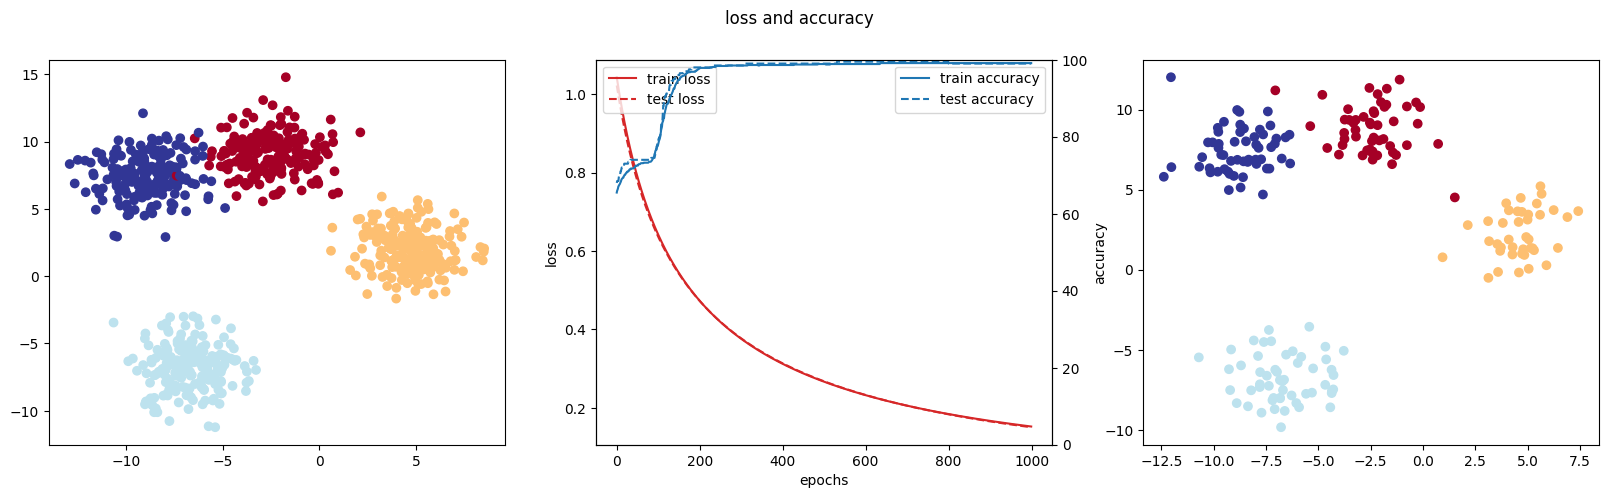

In [13]:
model_0.eval() 
with torch.inference_mode():
  y_logits = model_0(X_test).squeeze()
  y_preds_probabilities = torch.softmax(y_logits, dim=1)
  y_preds = torch.argmax(y_preds_probabilities, dim=1)

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axis[0].scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap=plt.cm.RdYlBu)

plot_loss_and_accuracy(axis = axis[1],
                        fig = fig,
                        epoch_count = epoch_count,
                        loss_values = loss_values,
                        test_loss_values = test_loss_values,
                        acc_values = acc_values,
                        test_acc_values = test_acc_values
                        )

axis[2].scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_preds.cpu(), cmap=plt.cm.RdYlBu)